# Simulation of Sequences

In [1]:
import numpy as np
import qutip
import matplotlib.pyplot as plt

import pulser
from pulser_simulation import QutipEmulator

To illustrate the simulation of sequences, let us study a simple one-dimensional system with periodic boundary conditions (a ring of atoms):

In [3]:
# Setup
L = 14

# Define a ring of atoms distanced by a blockade radius distance:
Omega_max = 2.3 * 2 * np.pi
U = Omega_max / 2.3
R_interatomic = pulser.devices.MockDevice.rydberg_blockade_radius(Omega_max)

coords = (
    R_interatomic
    / (2 * np.tan(np.pi / L))
    * np.array(
        [
            (np.cos(theta * 2 * np.pi / L), np.sin(theta * 2 * np.pi / L))
            for theta in range(L)
        ]
    )
)

reg = pulser.Register.from_coordinates(coords, prefix="atom")

Draw register with **half** the blockade radii. Atoms have a significant interaction if their circles overlap. Draw the graph between interacting atoms using `draw_graph`.

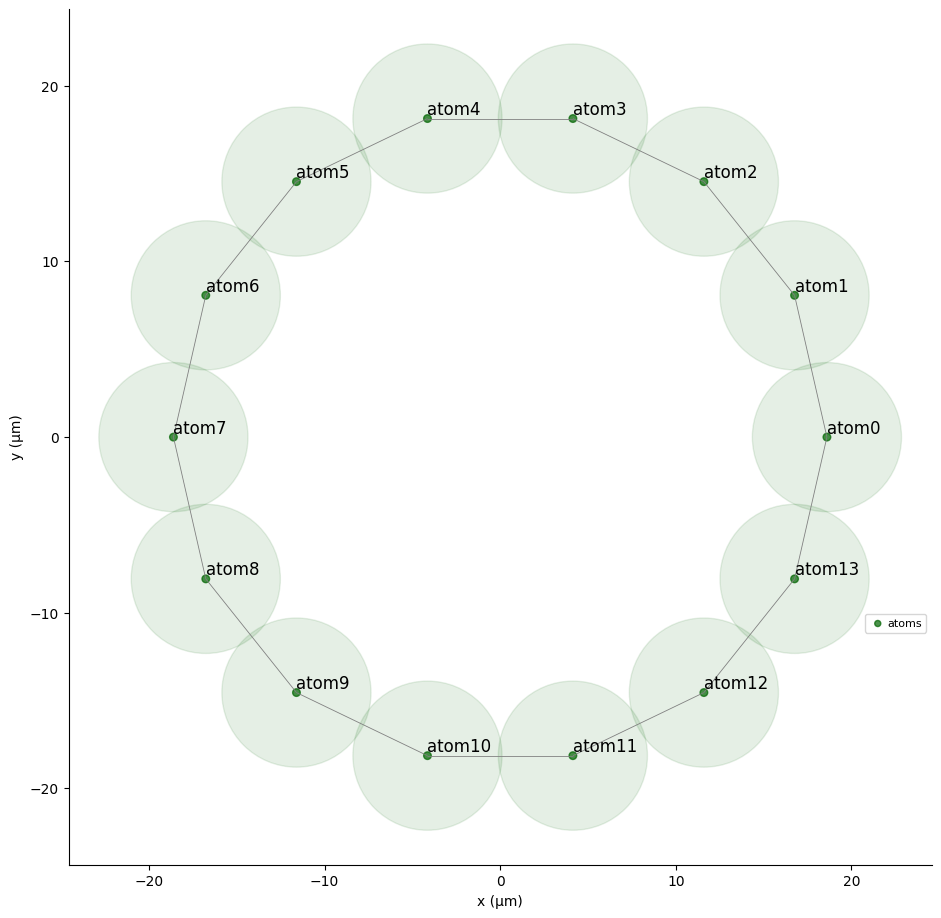

In [5]:
reg.draw(blockade_radius=R_interatomic, draw_half_radius=True, draw_graph=True)

Use pulse sequence for preparing a state with *antiferromagnetic order*.

In [12]:
delta_0 = -3 * U
delta_f = 1 * U

t_rise = 2000
t_fall = 2000
t_sweep = (delta_f - delta_0) / (2 * np.pi * 10) * 5000

rise = pulser.Pulse.ConstantDetuning(
    pulser.waveforms.RampWaveform(t_rise, 0.0, Omega_max), delta_0, 0.0
)
sweep = pulser.Pulse.ConstantAmplitude(
    Omega_max, pulser.waveforms.RampWaveform(t_sweep, delta_0, delta_f), 0.0
)
fall = pulser.Pulse.ConstantDetuning(
    pulser.waveforms.RampWaveform(t_fall, Omega_max, 0.0), delta_f, 0.0
)

seq = pulser.Sequence(reg, pulser.devices.MockDevice)
seq.declare_channel("ising", "rydberg_global")

seq.add(rise, "ising")
seq.add(sweep, "ising")
seq.add(fall, "ising")

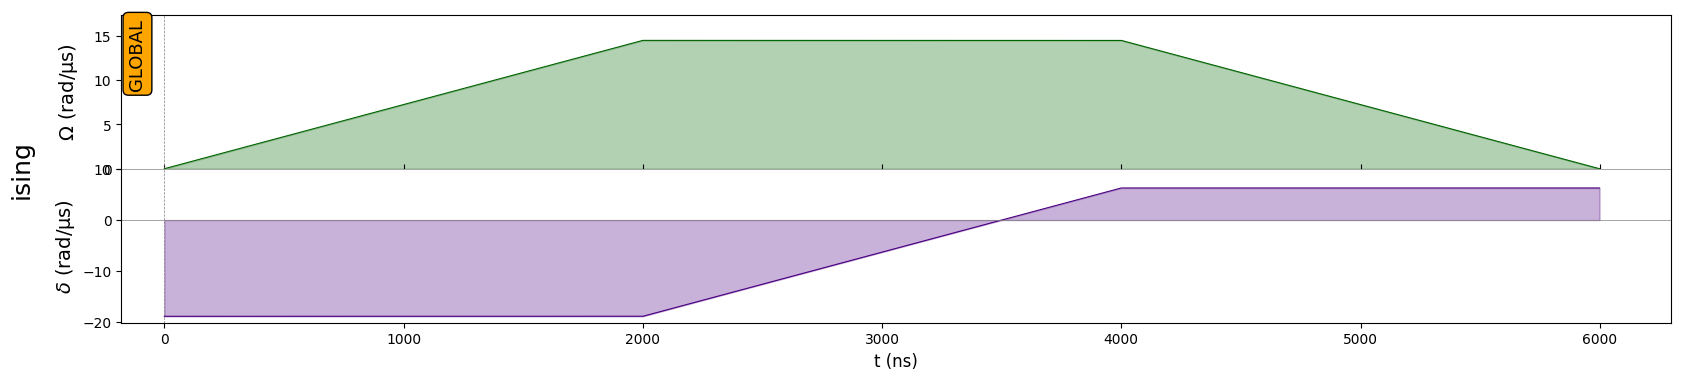

In [14]:
seq.draw()

[Cf. Bernien _et al._, Nature **551**, 579–584 (2017) & Scholl _et al._, Nature **595**, 233–238 (2021)]

## Running a Simulation

First we define our `QutipEmulator` object, which creates an internal respresentation of the quantum system, including the Hamiltonian which will drive the evolution:

In [8]:
sim = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
results = sim.run(progress_bar=True)

10.0%. Run time:   0.70s. Est. time left: 00:00:00:06
20.0%. Run time:   1.42s. Est. time left: 00:00:00:05
30.0%. Run time:   2.27s. Est. time left: 00:00:00:05
40.0%. Run time:   3.31s. Est. time left: 00:00:00:04
50.0%. Run time:   4.51s. Est. time left: 00:00:00:04
60.0%. Run time:   5.77s. Est. time left: 00:00:00:03
70.0%. Run time:   7.15s. Est. time left: 00:00:00:03
80.0%. Run time:   8.48s. Est. time left: 00:00:00:02
90.0%. Run time:   9.68s. Est. time left: 00:00:00:01
Total run time:  10.70s


Notice we have included the parameter `sampling_rate` which allows us to determine how many samples from the pulse sequence we wish to simulate. In the case of the simple shapes in our sequence, only a very small fraction is needed. This largely accelerates the simulation time in the solver.

To run the simulation we simply apply the method `run()`. At the time of writing of this notebook, the method uses a series of routines from **QuTiP** for solving the Schröedinger equation of the system. It returns a `SimulationResults` object, which will allow the study or post-processing of the states for each time step in our simulation. Additionally, we can include a progress bar to have an estimate of how the simulation is advancing:

## Exploring the `SimulationResults` object
The `SimulationResults` object that we created contains the quantum state at each time step. We can call them using the `states` attribute.

Looking at a random time:

In [10]:
results.states[23]  # Given as a `qutip.Qobj` object

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (16384, 1), type = ket
Qobj data =
  (0, 0)	(-4.3689513513433944e-21+3.253880840034327e-21j)
  (1, 0)	(1.6168153691873233e-19-1.5292107940244707e-19j)
  (2, 0)	(1.6168153691873158e-19-1.529210794024465e-19j)
  (3, 0)	(-3.755013673413672e-18+5.0432679234558805e-18j)
  (4, 0)	(1.6168153691873238e-19-1.5292107940244727e-19j)
  (5, 0)	(-6.1884090887297985e-18+7.238424823747307e-18j)
  (6, 0)	(-3.755013673413676e-18+5.0432679234558774e-18j)
  (7, 0)	(7.888766110685524e-17-1.575207109049675e-16j)
  (8, 0)	(1.6168153691873324e-19-1.5292107940244835e-19j)
  (9, 0)	(-5.734758591157331e-18+6.918122724647869e-18j)
  (10, 0)	(-6.188409088729801e-18+7.238424823747309e-18j)
  (11, 0)	(1.3716801426727262e-16-2.3162747067267243e-16j)
  (12, 0)	(-3.7550136734137035e-18+5.043267923455907e-18j)
  (13, 0)	(1.3716801426727237e-16-2.31627470672673e-16j)
  (14, 0)	(7.888766110685509e-17-1.

We can sample the final state directly, using the `sample_final_state()` method from the `SimulationResults` object. We try it with $1000$ samples and discard the less frequent bitstrings:

<BarContainer object of 38 artists>

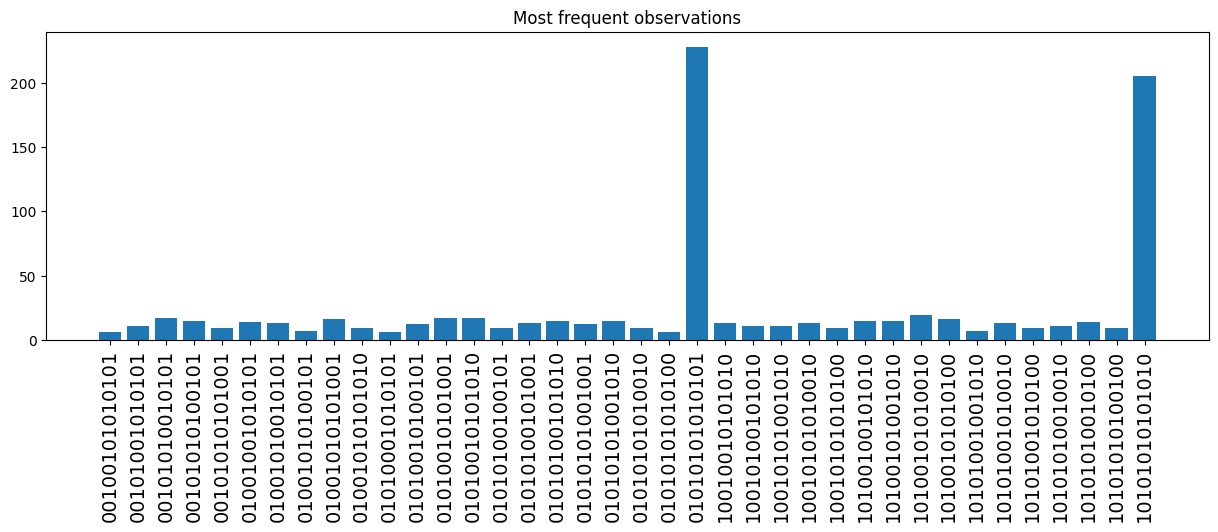

In [11]:
counts = results.sample_final_state(N_samples=1000)

large_counts = {k: v for k, v in counts.items() if v > 5}

plt.figure(figsize=(15, 4))
plt.xticks(rotation=90, fontsize=14)
plt.title("Most frequent observations")
plt.bar(large_counts.keys(), large_counts.values())

Notice how the most frequent bitstrings correspond to the antiferromagnetic order states.

We can learn more by evaluating operator expectation values, for instance the average magnetization:
$$
\langle S_z \rangle = \frac{1}{L} \sum_{i = 1}^L \langle S_z^{(i)} \rangle.
$$

In [15]:
def local_magn(i):
    prod = L * [qutip.qeye(2)]
    prod[i] = qutip.sigmaz()
    return qutip.tensor(prod)

magn_av = 1/L * sum([local_magn(i) for i in range(L)])

Text(0, 0.5, '$\\langle S_z \\rangle$')

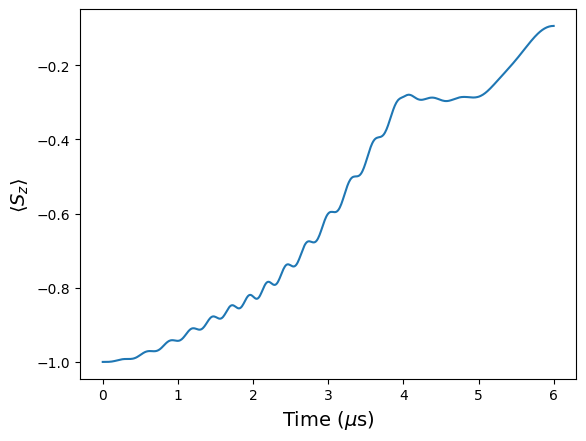

In [16]:
expect_magnetization = [qutip.expect(magn_av, state) for state in results.states]
plt.plot(sim.evaluation_times,
        expect_magnetization)

plt.xlabel("Time ($\mu$s)", fontsize = 14)
plt.ylabel(r"$\langle S_z \rangle$", fontsize = 14)

### Correlations
Define the correlation as
$$
\mathcal{C} = \frac{1}{L} \sum_{i=1}^{L} \left[\langle S_i S_{i + 1} \rangle - \langle S_i \rangle \langle S_{i + 1} \rangle \right].
$$
Then we have Néel (anti-ferromagnetic) order if $\mathcal{C} < 0$.

In [19]:
def neel(i, j):
    prod = L * [qutip.qeye(2)]
    prod[i] = qutip.sigmaz()
    prod[j] = qutip.sigmaz()
    return qutip.tensor(prod)

neel_av = 1/L * sum([neel(i, (i + 1) % L) for i in range(L)])
order_parameter = [qutip.expect(neel_av, state) - qutip.expect(magn_av, state)**2 for state in results.states]

Text(0, 0.5, '$\\mathcal{C}$')

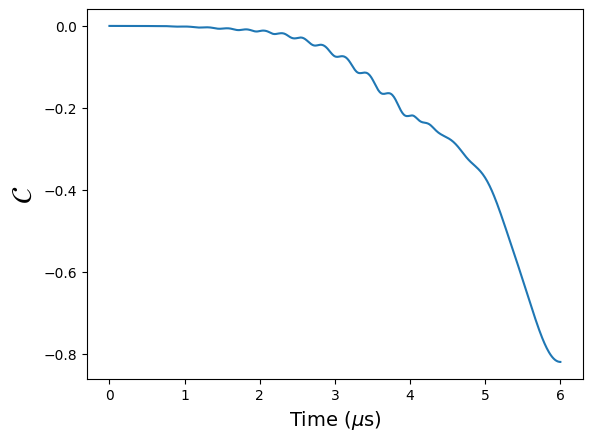

In [20]:
plt.plot(sim.evaluation_times,
         order_parameter)
plt.xlabel("Time ($\mu$s)", fontsize = 14)
plt.ylabel(r"$\mathcal{C}$", fontsize = 20)

### Further study?
- Correlation length
- How all this changes as a function of sweep speed (slower should be better).